# Connect Drive and Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025")

['RNA_Seq_transcriptom_meta_data.csv',
 'methylation_data.csv',
 'methylation_data_meta.csv',
 'rna_seq_meta.csv',
 'rna_seq_expr.csv',
 'proteomics_data_meta.csv',
 'proteomics_data.csv',
 'processed_data',
 'proteom_processed_data.csv',
 'methylation_processed_data.csv',
 'mirna_data.csv',
 'mirna_meta.csv',
 'miran_preprocessd.csv',
 'proteomics_processed_data.csv',
 'rna_processed_data.csv']

In [3]:
df_rna = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/rna_processed_data.csv")
df_mirna = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/miran_preprocessd.csv")
df_meth = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/methylation_processed_data.csv")
df_proteom = pd.read_csv("/content/drive/MyDrive/Datasets/TCGA_SKCM/New_Data_18022025/proteomics_processed_data.csv")

In [4]:
df_rna.shape, df_mirna.shape, df_meth.shape, df_proteom.shape

((471, 1001), (448, 1001), (472, 1001), (351, 1001))

## Concatinate Omics Dataset Vertically

In [5]:
df = pd.concat([df_rna, df_mirna, df_meth, df_proteom], axis = 0)
df.shape

(1742, 1001)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Sample_type
0,16.263203,0.327299,0.000000,19.769138,1.581432,1.269175,5.351663,5.258758,2.957267,2.212316,...,0.000000,12.406640,21.054990,4.604846,0.000000,0.000000,0.0,7.330823,13.886055,1
1,0.000000,4.739954,6.203649,0.000000,0.000000,4.964786,0.000000,0.000000,0.000000,0.000000,...,8.739338,0.000000,0.000000,0.000000,5.880862,4.467977,0.0,0.000000,0.000000,1
2,7.760679,8.664506,0.000000,5.489813,0.000000,12.020173,3.703621,0.000000,0.000000,0.000000,...,0.000000,3.664126,6.922591,0.000000,7.129135,0.000000,0.0,7.744801,0.000000,0
3,6.904083,0.000000,0.000000,9.955594,1.360067,0.510893,3.116695,3.584064,2.645634,0.595100,...,0.000000,8.214947,10.884281,4.840510,0.000000,0.000000,0.0,2.877843,7.540813,0
4,0.000000,6.457442,9.758096,0.000000,0.000000,3.386960,0.000000,0.000000,0.000000,0.000000,...,14.779585,0.000000,0.000000,0.000000,6.541218,9.668518,0.0,0.000000,0.000000,1


## Seperatre X and y

In [43]:
X = df.drop("Sample_type", axis = 1)
y = df["Sample_type"]

In [44]:
X.shape, y.shape

((1742, 1000), (1742,))

In [45]:
len(y)

1742

Classes: Sample_type
1    1348
0     394
Name: count, dtype: int64


Text(0.5, 0, "Index([1, 0], dtype='int64', name='Sample_type')")

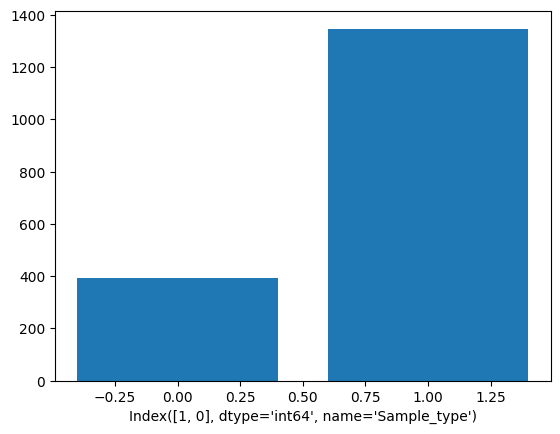

In [78]:
target_var = pd.Series(y).value_counts()
print(f"Classes: {target_var}")
plt.bar(target_var.index, target_var)
plt.xlabel(target_var.index)

Index([1, 0], dtype='int64')

### Missing Values Checking

In [8]:
# plt.figure(figsize = (12, 6))
# sns.heatmap(X, cmap = "viridis", cbar = False, yticklabels=False)
# plt.show()

In [8]:
X.isna().sum().sum()

0

##  Data Set Up

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim

## Data_Setup.py

In [51]:
!pip install imbalanced-learn

In [71]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""

import os
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import ADASYN
from collections import Counter

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    data, # data
    target, # classes
    batch_size, # Number of batch
    transform = True,
    num_workers: int = NUM_WORKERS, # cpu count
    test_size: float = .2
  ):
  """Creates training and testing DataLoaders.

  Takes in a training data and testing data path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    data: independent data
    target: dependent data
    transform: scalling transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use Data to create data loader

  # Class Names
  class_names = target.unique()
  if transform:
    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(data)
  else:
    data_norm = data
  X_train, X_test, y_train, y_test = train_test_split(data_norm, target, test_size = test_size)

  #! Need to USE OVER SAMPLING
  adasyn = ADASYN(random_state=42)
  X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
  # Convert to PyTorch tensors
  X_train_tensor = torch.FloatTensor(X_resampled)
  X_test_tensor = torch.FloatTensor(X_test)
  y_train_tensor = torch.LongTensor(y_resampled.to_numpy())
  y_test_tensor = torch.LongTensor(y_test.to_numpy())

  # Creating Data Loader
  train_dataloader = DataLoader(
      dataset=TensorDataset(X_train_tensor, y_train_tensor),
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True
  )

  test_dataloader = DataLoader(
      dataset=TensorDataset(X_test_tensor, y_test_tensor),
      batch_size=batch_size,
      shuffle=False,  # Don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True
  )
  return train_dataloader, test_dataloader, class_names

Overwriting going_modular/data_setup.py


In [72]:
import torch
import torch.nn as nn
import torch.utils.data as data
from going_modular import data_setup

In [77]:
BATCH_SIZE = 32
train_loader, test_loader, class_names = data_setup.create_dataloaders(
    data=X,
    target=y,
    batch_size=BATCH_SIZE,
    transform=True,
)

In [74]:
class_names

array([1, 0])

### Device Agnostic Code

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Transformer Model

In [15]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch Model code to instantiate a Transformer mode
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GeneTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.3):
        super(GeneTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=nhead,
                                                    dim_feedforward=dim_feedforward,
                                                    dropout=dropout,
                                                    activation="gelu",
                                                    batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)  # Adaptive pooling for better feature aggregation

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.LayerNorm(d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )

    def forward(self, x):
      x = self.embedding(x).unsqueeze(1)  # Reshape to (batch, seq_len=1, d_model)
      x = self.pos_encoder(x)  # Apply positional encoding
      x = self.transformer(x)  # Pass through Transformer layers
      x = self.pooling(x.transpose(1, 2)).squeeze(2)  # Adaptive pooling
      x = self.classifier(x)  # Classifier
      return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


Overwriting going_modular/model_builder.py


In [27]:
# input_dim = X_train_tensor.shape[1]
# classes = len(y_train.unique())
# lr = 0.001
# model = GeneTransformer(input_dim = input_dim, num_classes=classes).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = lr)

In [16]:
X.shape[1],len(class_names)

(1000, 2)

In [76]:
import torch
# Import model_builder.py
from going_modular import model_builder

torch.manual_seed(42)
# Instantiate an instance of the model from the "model_builder.py" script
input_dim = X.shape[1]
lr = 0.001
classes = len(class_names)

#d_model=128, nhead=8, num_layers=4
model = model_builder.GeneTransformer(input_dim = input_dim,
                                      num_classes = classes,
                                      d_model = 256,
                                      nhead = 16,
                                      num_layers = 8).to(device)

In [66]:
model

GeneTransformer(
  (embedding): Linear(in_features=1000, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

## Training and Testing Loop

In [20]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch_x, batch_y in dataloader:
      # Send data to target device
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # 1. Forward pass
      y_pred = model(batch_x)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, batch_y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == batch_y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch_x, batch_y in dataloader:
          # Send data to target device
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)

          # 1. Forward pass
          test_pred_logits = model(batch_x)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, batch_y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == batch_y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Overwriting going_modular/engine.py


## Creating Function to save the model (utils.py)

In [23]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting going_modular/utils.py


## Train, evaluate and save the model (train.py)

In [68]:
from going_modular import engine

results = engine.train(model = model,
             train_dataloader = train_loader,
             test_dataloader = test_loader,
             optimizer = optimizer,
             loss_fn = criterion,
             epochs = 10,
             device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5578 | train_acc: 0.7601 | test_loss: 0.5183 | test_acc: 0.7874
Epoch: 2 | train_loss: 0.5548 | train_acc: 0.7683 | test_loss: 0.5223 | test_acc: 0.7874
Epoch: 3 | train_loss: 0.5441 | train_acc: 0.7696 | test_loss: 0.5210 | test_acc: 0.7874
Epoch: 4 | train_loss: 0.5453 | train_acc: 0.7690 | test_loss: 0.5279 | test_acc: 0.7874
Epoch: 5 | train_loss: 0.5426 | train_acc: 0.7702 | test_loss: 0.5176 | test_acc: 0.7874
Epoch: 6 | train_loss: 0.5421 | train_acc: 0.7702 | test_loss: 0.5218 | test_acc: 0.7874
Epoch: 7 | train_loss: 0.5466 | train_acc: 0.7696 | test_loss: 0.5183 | test_acc: 0.7874
Epoch: 8 | train_loss: 0.5405 | train_acc: 0.7715 | test_loss: 0.5182 | test_acc: 0.7874
Epoch: 9 | train_loss: 0.5459 | train_acc: 0.7683 | test_loss: 0.5175 | test_acc: 0.7874
Epoch: 10 | train_loss: 0.5449 | train_acc: 0.7702 | test_loss: 0.5174 | test_acc: 0.7874


Class of  results: <class 'dict'>
Keys of results: dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])


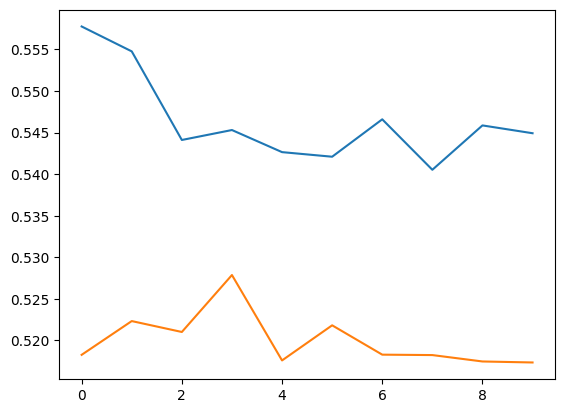

In [69]:
print(f"Class of  results: {type(results)}")
print(f"Keys of results: {results.keys()}")
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])

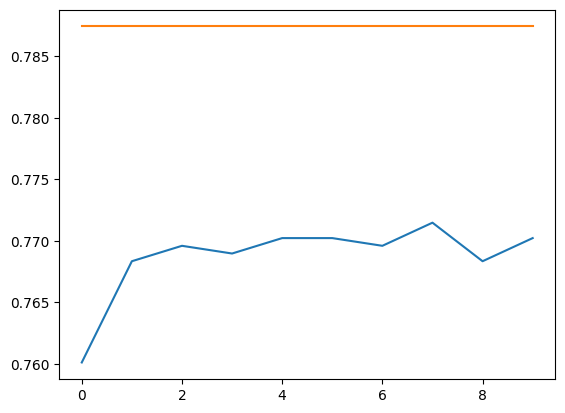

In [70]:
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])

In [79]:
device

device(type='cuda')